VGG16

VGG16 is a CNN architecture renowned for its simplicity and effectiveness. It comprises 16 layers, including convolutional and pooling layers, culminating in three fully connected layers. Despite its depth, VGG16's architecture is straightforward, making it a popular choice for transfer learning and feature extraction in various computer vision applications.

In [ ]:
!pip install split-folders

Defaulting to user installation because normal site-packages is not writeable


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
import splitfolders

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter
from timeit import default_timer as timer
import matplotlib.pyplot as plt

import os
from os import listdir
from os.path import isfile, join

In [ ]:
os.makedirs('output')
os.makedirs('output/train')
os.makedirs('output/val')

In [ ]:
img_loc = "C:/Users/Student/Documents/archive (1)"

splitfolders.ratio(img_loc, output='output', seed=1, ratio=(0.8, 0.2))

Copying files: 2750 files [00:02, 1117.39 files/s]


In [ ]:
!ls output

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
train_loc = 'output/train/'
test_loc = 'output/val/'

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 2200 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


In [ ]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

553467096/553467096 [==============================] - 177s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                          

In [ ]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-16:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name)

Layer 'block3_conv1' is trainable
Layer 'block3_conv2' is trainable
Layer 'block3_conv3' is trainable
Layer 'block3_pool' is trainable
Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


In [ ]:
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy,
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
checkpoint = ModelCheckpoint("vgg16_diabetes.h5", monitor='val_accuracy', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
counter = Counter(traindata.classes)
max_val = float(max(counter.values()))
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 1.0,
 1: 2.7027027027027026,
 2: 1.1111111111111112,
 3: 3.4482758620689653,
 4: 5.2631578947368425}

In [ ]:
start=timer()
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata,
                 class_weight=class_weights, validation_steps=testdata.samples//testdata.batch_size,
                 epochs=75,callbacks=[checkpoint,early])
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

Epoch 1/75



68/68 [==============================] - ETA: 0s - loss: 66.1281 - accuracy: 0.2288
Epoch 1: val_accuracy improved from -inf to 0.36581, saving model to vgg16_diabetes.h5


C:\Users\Student\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


68/68 [==============================] - 443s 6s/step - loss: 66.1281 - accuracy: 0.2288 - val_loss: 6.7517 - val_accuracy: 0.3658
Epoch 2/75
68/68 [==============================] - ETA: 0s - loss: 5.5815 - accuracy: 0.2449
Epoch 2: val_accuracy improved from 0.36581 to 0.43382, saving model to vgg16_diabetes.h5
68/68 [==============================] - 434s 6s/step - loss: 5.5815 - accuracy: 0.2449 - val_loss: 1.3691 - val_accuracy: 0.4338
Epoch 3/75
68/68 [==============================] - ETA: 0s - loss: 3.0053 - accuracy: 0.3672
Epoch 3: val_accuracy did not improve from 0.43382
68/68 [==============================] - 427s 6s/step - loss: 3.0053 - accuracy: 0.3672 - val_loss: 1.5523 - val_accuracy: 0.0956
Epoch 4/75
68/68 [==============================] - ETA: 0s - loss: 3.7493 - accuracy: 0.3639
Epoch 4: val_accuracy did not improve from 0.43382
68/68 [==============================] - 426s 6s/step - loss: 3.7493 - accuracy: 0.3639 - val_loss: 1.4128 - val_accuracy: 0.3529
Epoch

Epoch 31/75
68/68 [==============================] - ETA: 0s - loss: 1.8503 - accuracy: 0.6204
Epoch 31: val_accuracy did not improve from 0.66544
68/68 [==============================] - 426s 6s/step - loss: 1.8503 - accuracy: 0.6204 - val_loss: 0.9456 - val_accuracy: 0.6158
Epoch 32/75
68/68 [==============================] - ETA: 0s - loss: 1.8487 - accuracy: 0.6268
Epoch 32: val_accuracy did not improve from 0.66544
68/68 [==============================] - 427s 6s/step - loss: 1.8487 - accuracy: 0.6268 - val_loss: 1.0119 - val_accuracy: 0.5662
Epoch 33/75
68/68 [==============================] - ETA: 0s - loss: 1.8043 - accuracy: 0.6268
Epoch 33: val_accuracy did not improve from 0.66544
68/68 [==============================] - 427s 6s/step - loss: 1.8043 - accuracy: 0.6268 - val_loss: 0.9163 - val_accuracy: 0.6268
Epoch 34/75
68/68 [==============================] - ETA: 0s - loss: 1.8151 - accuracy: 0.6158
Epoch 34: val_accuracy did not improve from 0.66544
68/68 [===============

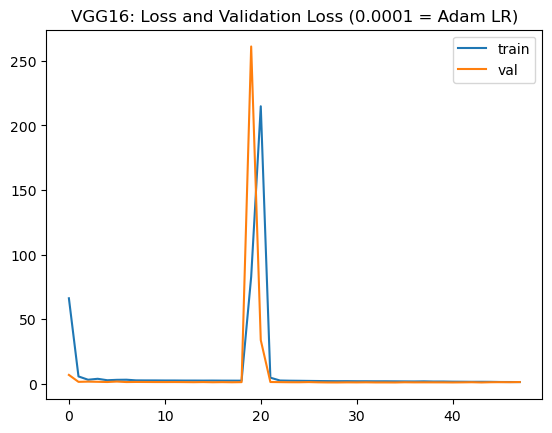

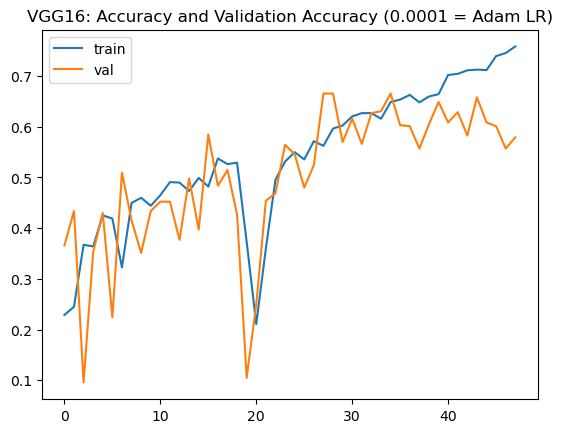

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('VGG16: Loss and Validation Loss (0.0001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('VGG16: Accuracy and Validation Accuracy (0.0001 = Adam LR)')
plt.legend();
plt.show()